# ML CUP - Neural Networks
In this notebook we will study the application of neural networks to the ML CUP.
Firs we will study the effect of different optimizers (SGD, Adam, RMSProp).
Then we will introduce a decaying lr using ReduceLROnpPlateau, and study the effects of this callback.
A more detailed explanation of our pipeline is in the presentation slides.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from itertools import product

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the figure suptitle
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
def plot_training_curves(train_losses, test_losses, train_mees, test_mees, hyperparams):
    """
    Plot training and test curves for loss and Mean Euclidean Error (MEE).

    Parameters:
    - epoch (int): The total number of training epochs.
    - train_losses (list): List of training losses for each epoch.
    - test_losses (list): List of test losses for each epoch.
    - train_mees (list): List of training MEE values for each epoch.
    - test_mees (list): List of test MEE values for each epoch.
    - hyperparams (list): List of hyperparameters used for the plot.

    Returns:
    None

    Plots four subplots:
    1. Training and test loss curves.
    2. Training and test MEE curves.
    3. Zoomed-in training and test loss curves with y-axis limit [0, 10].
    4. Zoomed-in training and test MEE curves with y-axis limit [0, 10].

    The hyperparameters are used in the plot title to provide additional context.
    """

    plt.figure(figsize=(18, 8))
    plt.suptitle(f'Batch Size={hyperparams[3]},Activation Function={hyperparams[5]}, Layers={hyperparams[6]} Hidden Units={hyperparams[0]}, Eta={hyperparams[1]}, Alpha={hyperparams[2]}, Lambda={hyperparams[4]}, dropout = {hyperparams[7]}')
    # Loss plots
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training MSE', color = 'red')
    plt.plot(test_losses, label='Validation MSE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 2)
    plt.plot(train_mees, label='Training MEE', color='red')
    plt.plot(test_mees, label='Validation MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.legend()

    # Loss plots
    plt.subplot(2, 2, 3)
    plt.plot(train_losses, label='Training MSE', color = 'red')
    plt.plot(test_losses, label='Validation MSE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.ylim(0,10)
    plt.legend()

    # MEE plots
    plt.subplot(2, 2, 4)
    plt.plot(train_mees, label='Training MEE', color='red')
    plt.plot(test_mees, label='Validation MEE', color = 'blue', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('MEE')
    plt.ylim(0,10)
    plt.legend()

    plt.tight_layout()

    plt.show()

In [5]:
def mean_euclidean_error(tensor1, tensor2):
    """
    Compute the mean Euclidean error between two sets of 3D vectors.

    Parameters:
    - tensor1: PyTorch tensor of size (N, 3) representing the first set of 3D vectors
    - tensor2: PyTorch tensor of size (N, 3) representing the second set of 3D vectors

    Returns:
    - mean_error: Mean Euclidean error between the two sets of vectors
    """
    # Check if the tensors have the correct shape
    if tensor1.shape[1] != 3 or tensor2.shape[1] != 3 or tensor1.shape[0] != tensor2.shape[0]:
        raise ValueError("Input tensors must be of size (N, 3)")


    # Compute Euclidean distance
    euclidean_distance = torch.norm(tensor1 - tensor2, dim=1)

    # Calculate the mean Euclidean error
    mean_error = torch.mean(euclidean_distance)

    return mean_error.item()

In [6]:
# Define a regression eural network

class RegressorNN(nn.Module):
    def __init__(self, hidden_size, activation_function, num_layers, dropout_prob, input_size=10, output_size=3):
        super(RegressorNN, self).__init__()

        # Input layer
        self.layers = [nn.Linear(input_size, hidden_size)]

        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(activation_function)
            self.layers.append(nn.Dropout(p=dropout_prob))  # Add dropout layer

        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))

        # Create a Sequential container for the layers
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def training_model(x_train, y_train, x_test, y_test, neuron_number,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor, lr_patience, optimiz, num_epochs=1000, plot_curves=False, return_history=False):
    """
    Train the regression model and evaluate it on a test (can also be validation, depending on the context).


    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test/Validation input data.
    - y_test (torch.Tensor): Test/Validation target data.
    - neuron_number (int): Total number of neurons in the network.
    - learning_rate (float): Initial learning rate for the optimizer.
    - momentum (float): Momentum factor for optimizers that use it.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function used in the model.
    - layers (int): Number of hidden layers in the model.
    - dropout (float): Dropout rate for regularization.
    - factor (float): Factor by which the learning rate will be reduced.
    - lr_patience (int): Number of epochs with no improvement after which learning rate will be reduced.
    - optimiz (str): Optimizer to use ('SGD', 'Adam', or 'RMS').
    - num_epochs (int, optional): Total number of training epochs (default: 1000).
    - plot_curves (bool, optional): If True, plots training and test(validation) loss and MEE curves (default: False).
    - return_history (bool, optional): If True, returns the training history (default: False).

    Returns:
    - tuple: Depending on 'return_history', returns either the final model and its performance metrics
      (model, number of epochs, final training loss, final test loss, final training MEE, final test MEE),
      or the model, performance metrics, and the training history
      (model, number of epochs, final training loss, final test loss, final training MEE, final test MEE,
      array of training losses, array of test losses, array of training MEEs, array of test MEEs).
    """

    hidden_size = int(neuron_number/layers)
    # Create an instance of the model
    model = RegressorNN(hidden_size=hidden_size, dropout_prob=dropout, activation_function=activation, num_layers=layers)
    model.to(device)
    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    if optimiz == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)
    if optimiz == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_coeff)
    if optimiz == 'RMS':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=reg_coeff)

    # Set the initial learning rate and create a learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=lr_patience, verbose=True)

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

    # Lists to store training and test losses for plotting
    train_losses, test_losses, train_mees, test_mees = [], [], [], []

    # parameters to stop at training convergence
    min_mee = float('inf')
    patience_counter, patience = 0, 20

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for inputs, labels in train_dataloader:
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels) #Compute the loss

            optimizer.zero_grad()   # Zero the gradients
            loss.backward() # Backward pass
            optimizer.step()  # Update weights

        model.eval()  # Set the model to evaluation mode
        #calculate loss
        y_pred = model(x_train)
        train_loss = criterion(y_pred, y_train)
        # Calculate mee
        train_mee = mean_euclidean_error(y_pred,y_train)
        train_losses.append(train_loss.item())
        train_mees.append(train_mee)

        # Evaluation on the test/validation set
        with torch.no_grad():
            test_outputs = model(x_test)
            test_loss = criterion(test_outputs, y_test)

            # Calculate test mee
            test_mee = mean_euclidean_error(test_outputs,y_test)
            test_mees.append(test_mee)
            test_losses.append(test_loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}],Learning Rate: {optimizer.param_groups[0]["lr"]}, Loss: {train_loss.item():.4f}, '
            f'MEE: {train_mee:.4f} | Test - Epoch [{epoch+1}/{num_epochs}], '
            f'Loss: {test_loss.item():.4f} MEE: {test_mee:.4f} ', end='\r')

        # Check for convergence
        if train_mee < min_mee and abs(train_mee-min_mee)>1e-3:
            patience_counter = 0
            min_mee = train_mee
        else:
            patience_counter += 1

        if patience_counter == patience:
        #    print(f"Convergence reached. at epoch {epoch+1} Stopping training.")
            break

        # Update the learning rate using the scheduler
        scheduler.step(train_mee)

    print(f'N. Epochs = {epoch+1} - Loss (train | test/val )= ({train_loss.item():.4} | {test_loss.item():.4} ) - MEE (train | test/val ) = ({train_mee:.4} | {test_mee:.4} )')

    if plot_curves:
        hyperparams = [hidden_size,learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor,lr_patience, num_epochs]
        plot_training_curves(train_losses, test_losses, train_mees, test_mees, hyperparams)

    if return_history:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee, np.array(train_losses), np.array(test_losses), np.array(train_mees), np.array(test_mees)
    else:
        return model, epoch+1, train_loss.item(), test_loss.item(), train_mee, test_mee

In [8]:
def reshape_history(N,hist):
    """
    Truncate each history in a list to the length of the shortest history.

    Parameters:
    - N (int): Number of histories in the list.
    - hist (list of lists): A list where each element is a history (list of values like losses or accuracies).

    Returns:
    - list of lists: A list of histories, each truncated to the length of the shortest history in the original list.

    Each history in the list 'hist' is truncated to the length of the shortest history. This is needed because
    histories of different lengths are collected and they need to be averaged.
    """
    min_len = float('inf')
    for i in range(0,N):
        if len(hist[i]) < min_len:
            min_len = len(hist[i])

    for i in range(0,N):
        hist[i]=hist[i][:min_len]

    return hist

def train_with_different_initializations(x_train, y_train, x_test, y_test,
                                         neuron_number,learning_rate, momentum,
                                         bs, reg_coeff, activation,layers, dropout, factor, lr_patience,optimiz, max_num_epochs=1000,
                                         plot_curves=False, N = 5, return_history=False):
    """
    Train the model multiple times with different weight initializations to estimate performance mean and variance.

    Parameters:
    - x_train (torch.Tensor): Training input data.
    - y_train (torch.Tensor): Training target data.
    - x_test (torch.Tensor): Test input data.
    - y_test (torch.Tensor): Test target data.
    - neuron_number (int): Total number of neurons across all layers.
    - learning_rate (float): Learning rate for the optimizer.
    - momentum (float): Momentum for the optimizer.
    - bs (int): Batch size for training.
    - reg_coeff (float): Regularization coefficient for weight decay.
    - activation (torch.nn.Module): Activation function for the model.
    - layers (int): Number of hidden layers in the model.
    - dropout (float): Dropout rate for regularization.
    - factor (float): Factor by which the learning rate will be reduced.
    - lr_patience (int): Number of epochs with no improvement after which learning rate will be reduced.
    - optimiz (str): Optimizer to use ('SGD', 'Adam', 'RMSprop').
    - max_num_epochs (int): Maximum number of training epochs.
    - plot_curves (bool): Flag to plot training and validation loss and MEE curves.
    - N (int): Number of times to train the model with different initializations.
    - return_history (bool): Flag to return the history of losses and MEEs.

    Returns:
    If return_history is True:
    - models (list): List of trained models for each initialization.
    - train_losses_hist (list): List of training loss histories for each model.
    - test_losses_hist (list): List of test loss histories for each model.
    - train_mees_hist (list): List of training MEE histories for each model.
    - test_mees_hist (list): List of test MEE histories for each model.

    If return_history is False:
    - Mean of the final training loss across all initializations.
    - Mean of the final test loss across all initializations.
    - Mean of the final training MEE across all initializations.
    - Mean of the final test MEE across all initializations.

    Prints the mean and standard deviation of training and test loss, as well as training and test Mean Euclidean Error (MEE).
    """
    final_train_loss = []
    final_test_loss = []
    final_train_mee = []
    final_test_mee = []
    train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)],  [[] for _ in range(N)]
    models = []
    for i in range (0,N):
        model , num_epochs,train_loss, test_loss, train_mee, test_mee, train_losses_hist[i], test_losses_hist[i], train_mees_hist[i], test_mees_hist[i] = training_model(x_train,
                        y_train,
                        x_test,
                        y_test,
                        neuron_number,
                        learning_rate,
                        momentum,
                        bs,
                        reg_coeff,
                        activation,
                        layers,
                        dropout,
                        factor,
                        lr_patience,
                        optimiz,
                        plot_curves=False,
                        num_epochs=max_num_epochs,
                        return_history=True)


        final_train_loss.append(train_loss)
        final_test_loss.append(test_loss)
        final_train_mee.append(train_mee)
        final_test_mee.append(test_mee)
        models.append(model)

    if plot_curves:
        hyperparams = [int(neuron_number/layers),learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, num_epochs]
        plot_training_curves(train_losses=train_losses_hist[i],test_losses=test_losses_hist[i],train_mees=train_mees_hist[i],test_mees=test_mees_hist[i],hyperparams=hyperparams)

    plt.show()
    print(f'Avg of {N} initializations: Loss (train | test/val )= ({np.mean(final_train_loss):.4} +- {np.std(final_train_loss):.4} | {np.mean(final_test_loss):.4} +- {np.std(final_test_loss):.4})'
          f'- MEE (train | test/val ) = ( {np.mean(final_train_mee):.4} +-  {np.std(final_train_mee):.4} | {np.mean(final_test_mee):.4} +- {np.std(final_test_mee):.4})')

    if return_history:
        train_losses_hist = reshape_history(N,train_losses_hist)
        test_losses_hist = reshape_history(N,test_losses_hist)
        train_mees_hist = reshape_history(N,train_mees_hist)
        test_mees_hist = reshape_history(N,test_mees_hist)
        return models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist
    else:
        return np.mean(final_train_loss), np.mean(final_test_loss), np.mean(final_train_mee), np.mean(final_test_mee)

In [9]:
def perform_grid_search_kfold(neuron_numbers, learning_rates, momentums, batch_sizes, reg_coeffs, activations, layerss, dropouts,factors, lr_patiences, optimiz, k_folds, x, y, plot_curves=False, num_epochs=1000, number_of_init=5):
    """
    Perform grid search with k-fold cross-validation for hyperparameters.


    Parameters:
    - neuron_numbers (list): List of total neuron numbers to try in the network.
    - learning_rates (list): List of learning rates to try.
    - momentums (list): List of momentum values to try for optimizers that use it.
    - batch_sizes (list): List of batch sizes to try.
    - reg_coeffs (list): List of regularization coefficients to try for weight decay.
    - activations (list): List of activation functions to try.
    - layerss (list): List of numbers of layers to try.
    - dropouts (list): List of dropout rates to try for regularization.
    - factors (list): List of factors for reducing learning rate on plateau.
    - lr_patiences (list): List of patience values for reducing learning rate on plateau.
    - optimiz (str): Type of optimizer to use.
    - k_folds (int): Number of folds to use in k-fold cross-validation.
    - x (numpy.ndarray): Input feature data.
    - y (numpy.ndarray): Target data.
    - plot_curves (bool, optional): Whether to plot training and validation loss/MEE curves (default: False).
    - num_epochs (int, optional): Maximum number of training epochs for each model (default: 1000).
    - number_of_init (int): Number of different initializations to try for each hyperparameter set.

    Returns:
    - list: Best hyperparameters found through grid search and k-fold cross-validation, based on validation MEE.


    The function performs grid search with k-fold cross-validation for Monk classifier hyperparameters and returns the best hyperparameters.
    """

    best_mee = float('inf')
    best_hyperparams = []

    for neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor,lr_patience in product(neuron_numbers,learning_rates,momentums,batch_sizes, reg_coeffs, activations, layerss, dropouts, factors, lr_patiences):
        print(f'activation={activation}; layers={layers}; neuron_number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff}; optim = {optimiz}; factor={factor};lr_patience={lr_patience}')

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

        # Lists to store training and validation losses and MEEs for each fold
        train_losses, val_losses, train_mees, val_mees = [], [], [], []

        # Perform K-fold cross-validation
        for fold, (train_indices, val_indices) in enumerate(kf.split(x,y)):

            # Split the data into training and validation (or test) sets
            X_train, X_val = x[train_indices], x[val_indices]
            Y_train, Y_val = y[train_indices], y[val_indices]

            train_loss, val_loss, train_mee, val_mee = train_with_different_initializations(
                x_train=X_train, y_train=Y_train, x_test=X_val, y_test=Y_val,
                neuron_number=neuron_number, learning_rate=learning_rate, momentum=momentum,
                bs=bs, reg_coeff=reg_coeff, activation=activation, layers=layers,dropout=dropout,factor=factor, lr_patience=lr_patience, optimiz=optimiz ,plot_curves=plot_curves, max_num_epochs=num_epochs, N=number_of_init)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_mees.append(train_mee)
            val_mees.append(val_mee)

        print(f'Final Results: activation={activation}; layers={layers}; neuron number={neuron_number}; lr={learning_rate}; alpha = {momentum}; batch size = {bs}; lambda = {reg_coeff} --> '
            f'train_loss = {np.mean(train_losses):.4} +- {np.std(train_losses):.4} | '
            f'val_loss = {np.mean(val_losses):.4} +- {np.std(val_losses):.4}'
            f'train_mee = {np.mean(train_mees):.4} +- {np.std(train_mees):.4} | '
            f'val_mee = {np.mean(val_mees):.4} +- {np.std(val_mees):.4}')

        if np.mean(val_mees) < best_mee:

            best_mee = np.mean(val_mees)
            best_hyperparams = [neuron_number, learning_rate, momentum, bs, reg_coeff, activation, layers, dropout, factor, lr_patience]

    print(best_hyperparams,'n Best val MEE:',best_mee)
    return best_hyperparams

In [1]:
def plot_mean_std(N,train_hist, test_hist,label):
    """
    Plot the mean and standard deviation of training and testing metrics over epochs.

    Parameters:
    - N (int): The number of different initializations or runs.
    - train_hist (list of lists): A list containing N lists of training metrics, each corresponding to a different run.
    - test_hist (list of lists): A list containing N lists of testing metrics, each corresponding to a different run.
    - label (str): A label for the metric being plotted (e.g., 'Loss' or 'Accuracy').

    The function calculates the mean and standard deviation across runs for both training and testing metrics at each epoch.
    It then plots these as two subplots: one showing the entire range of the metric, and another zoomed in on the lower values to better visualize differences when metrics are small.

    The plotted lines show the mean value, and the shaded areas represent one standard deviation above and below the mean.

    Returns:
    None
    """

    mean_tr = np.array(train_hist).mean(axis=0)
    std_tr = np.array(train_hist).std(axis=0)
    mean_te = np.array(test_hist).mean(axis=0)
    std_te = np.array(test_hist).std(axis=0)

    plt.figure(figsize=(8, 8))
    plt.subplot(2,1,1)
    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'maroon', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr,  color='lightcoral', alpha=0.5)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='cadetblue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.legend()

    plt.subplot(2,1,2)

    plt.plot(mean_tr, label=f'Training {label} (mean $\pm$ std)', color = 'maroon', linewidth=1)
    plt.fill_between(range(0,len(train_hist[0])),mean_tr-std_tr, mean_tr+std_tr, color='lightcoral', alpha=0.5)

    plt.plot(mean_te, label=f'Test {label} (mean $\pm$ std)', color = 'blue', linestyle='--', linewidth=1)
    plt.fill_between(range(0,len(test_hist[0])),mean_te-std_te, mean_te+std_te, color='cadetblue', alpha=0.3)

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.ylim(0,10)
    plt.legend()
    plt.show()


# IMPORT THE DATASET

In [11]:
from sklearn.model_selection import train_test_split
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

#to use GPU
X = X.to(device)
y = y.to(device)

# Split the data into training and testing sets (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PERFORM GRID SEARCH TO FIND BEST HYPERPARAMETERS
- We compare different optimizers
- First we keep things simple and don't implement any decay in the lr

In [12]:
#study of the effect of activation functions (compare tanh and relu)
'''
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh(),nn.ReLU()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'or 'RMS'
'''

#study of the effect of regularization
'''
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-2,1e-3,1e-4,1e-5]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam' or 'RMS'
'''

#coarse grid search SGD
'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-3,1e-4,1e-5]
momentums = [0.5,0.8] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam' or 'RMS'
'''

#refined grid search SGD
'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4]
momentums = [0.7,0.8,0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam' or 'RMS'
'''

#coarse grid search Adam
'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam' or 'RMS'
'''

#finer grid search Adam
'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-4,2e-4,3e-4]
momentums = [0] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam' or 'RMS
'''

#coarse grid search RMSProp
'''
hidden_neurons = [100,1000] #total number of neurons
learning_rates = [1e-4,1e-5]
momentums = [0.7,0.8,0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam' or 'RMS'
'''

#refined grid search RMSProp
'''
hidden_neurons = [1000,2000,3000] #total number of neurons
learning_rates = [1e-5,2e-5,3e-5]
momentums = [0.85,0.90,0.95] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [1,2,3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam' or 'RMS'
'''


#final best hyperparameters found (without reducelronplateau)
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-5]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam' or 'RMS'


best_hp = perform_grid_search_kfold(hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    [0], #this value doesn't matter because:
                                    [1e10], #we don't want reducelronplateau to activate
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    number_of_init=3,
                                    plot_curves=True)

activation=Tanh(); layers=3; neuron_number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMS; factor=0;lr_patience=10000000000.0


KeyboardInterrupt: 

# ReduceLROnPlateau
Try to implement it and perform some grid searches

activation=Tanh(); layers=3; neuron_number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001; optim = RMS; factor=0.5;lr_patience=15
Epoch 01027: reducing learning rate of group 0 to 5.0000e-06.3009 | Test - Epoch [1027/5000], Loss: 0.2895 MEE: 0.6081     
Epoch 01140: reducing learning rate of group 0 to 2.5000e-06.2552 | Test - Epoch [1140/5000], Loss: 0.2790 MEE: 0.5766 
Epoch 01199: reducing learning rate of group 0 to 1.2500e-06.0.2419 | Test - Epoch [1199/5000], Loss: 0.2723 MEE: 0.5677 
Epoch 01221: reducing learning rate of group 0 to 6.2500e-07. 0.2388 | Test - Epoch [1221/5000], Loss: 0.2754 MEE: 0.5669 
N. Epochs = 1223 - Loss (train | test/val )= (0.02859 | 0.2728 ) - MEE (train | test/val ) = (0.2379 | 0.5639 )EE: 0.5639 
Epoch 00998: reducing learning rate of group 0 to 5.0000e-06.166 | Test - Epoch [998/5000], Loss: 0.2545 MEE: 0.5900       
Epoch 01174: reducing learning rate of group 0 to 2.5000e-06.2440 | Test - Epoch [1174/5000], Loss: 0.2389 MEE: 0.5539 

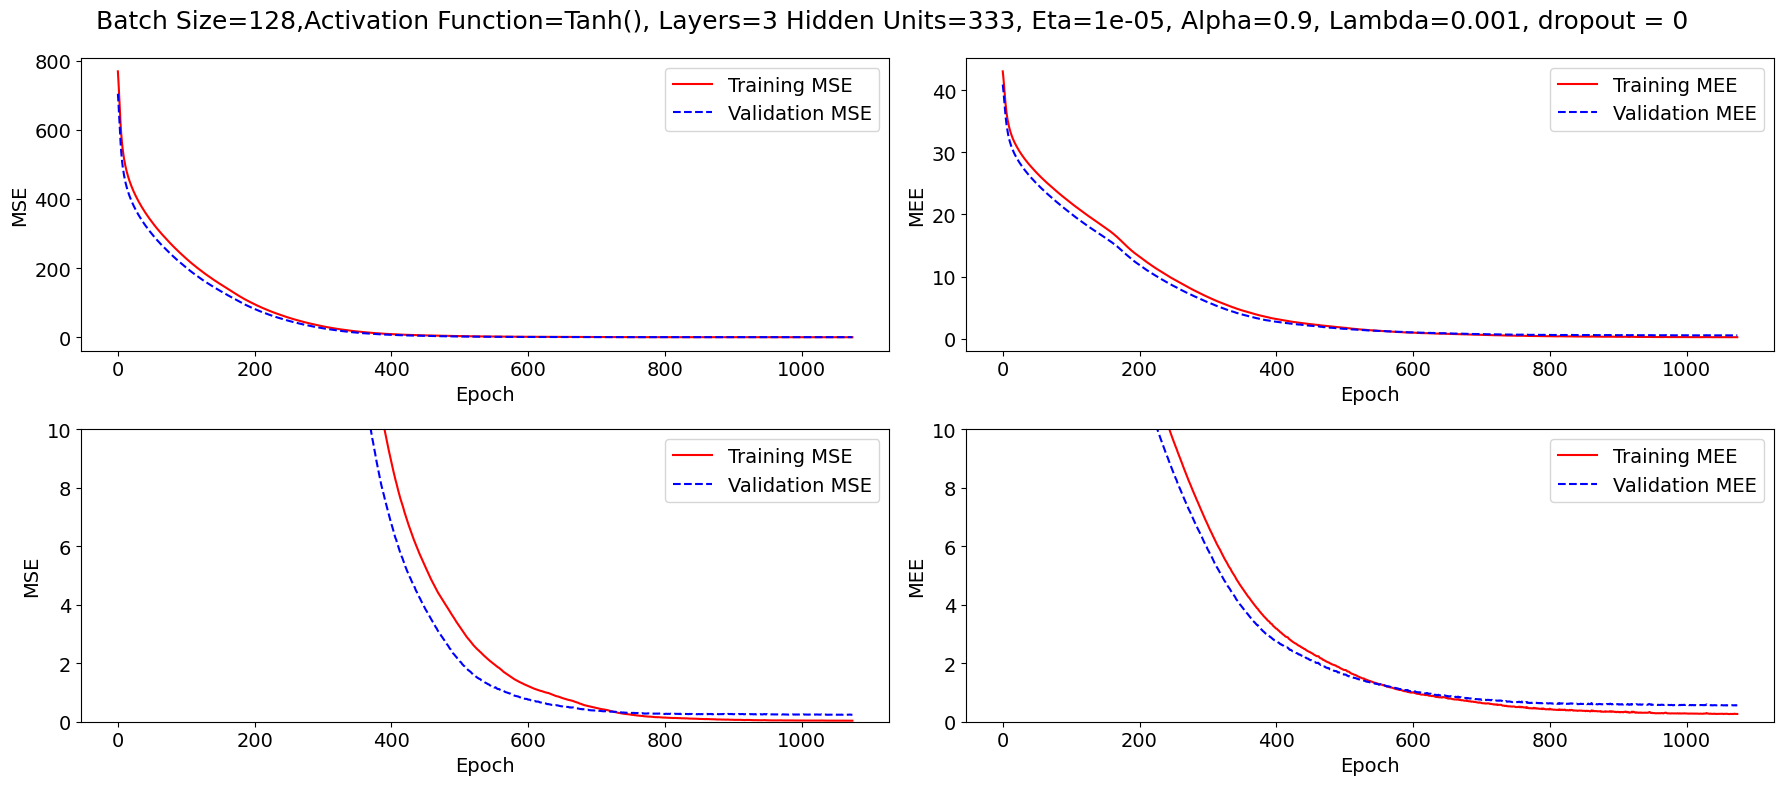

Avg of 3 initializations: Loss (train | test/val )= (0.03054 +- 0.003108 | 0.2509 +- 0.01556)- MEE (train | test/val ) = ( 0.2479 +-  0.01236 | 0.558 +- 0.007657)
N. Epochs = 931 - Loss (train | test/val )= (0.04544 | 0.5541 ) - MEE (train | test/val ) = (0.3054 | 0.8212 )0.8212     2 
Epoch 00920: reducing learning rate of group 0 to 5.0000e-06.998 | Test - Epoch [920/5000], Loss: 0.5009 MEE: 0.7888       
Epoch 00960: reducing learning rate of group 0 to 2.5000e-06.741 | Test - Epoch [960/5000], Loss: 0.4937 MEE: 0.7684 
Epoch 01122: reducing learning rate of group 0 to 1.2500e-06.0.2503 | Test - Epoch [1122/5000], Loss: 0.4716 MEE: 0.7535 
N. Epochs = 1151 - Loss (train | test/val )= (0.02932 | 0.4719 ) - MEE (train | test/val ) = (0.2453 | 0.7508 )EE: 0.7508 
N. Epochs = 924 - Loss (train | test/val )= (0.0463 | 0.4773 ) - MEE (train | test/val ) = (0.2985 | 0.7733 ) 0.7733       


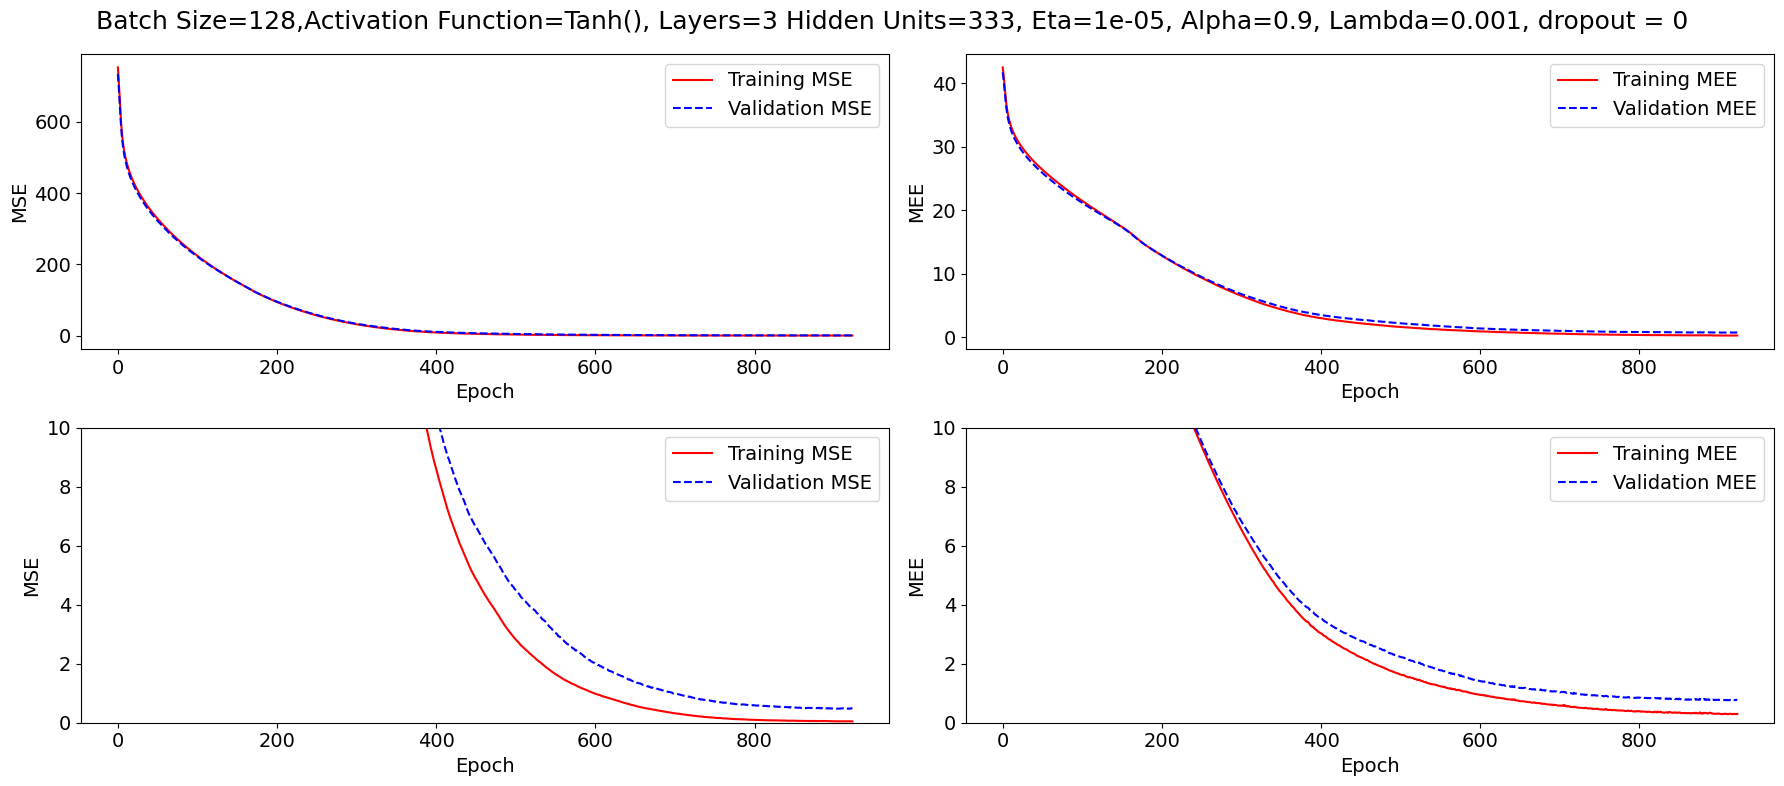

Avg of 3 initializations: Loss (train | test/val )= (0.04035 +- 0.007807 | 0.5011 +- 0.03755)- MEE (train | test/val ) = ( 0.2831 +-  0.02685 | 0.7818 +- 0.02935)
Epoch 00957: reducing learning rate of group 0 to 5.0000e-06.185 | Test - Epoch [957/5000], Loss: 0.4471 MEE: 0.8070       
N. Epochs = 991 - Loss (train | test/val )= (0.06641 | 0.4244 ) - MEE (train | test/val ) = (0.284 | 0.7735 ) 0.7735 
N. Epochs = 1035 - Loss (train | test/val )= (0.04052 | 0.3981 ) - MEE (train | test/val ) = (0.2684 | 0.7796 ) 0.7796     
Epoch 00978: reducing learning rate of group 0 to 5.0000e-06.832 | Test - Epoch [978/5000], Loss: 0.4102 MEE: 0.7955       
N. Epochs = 980 - Loss (train | test/val )= (0.05636 | 0.4115 ) - MEE (train | test/val ) = (0.28 | 0.8001 ): 0.8001 


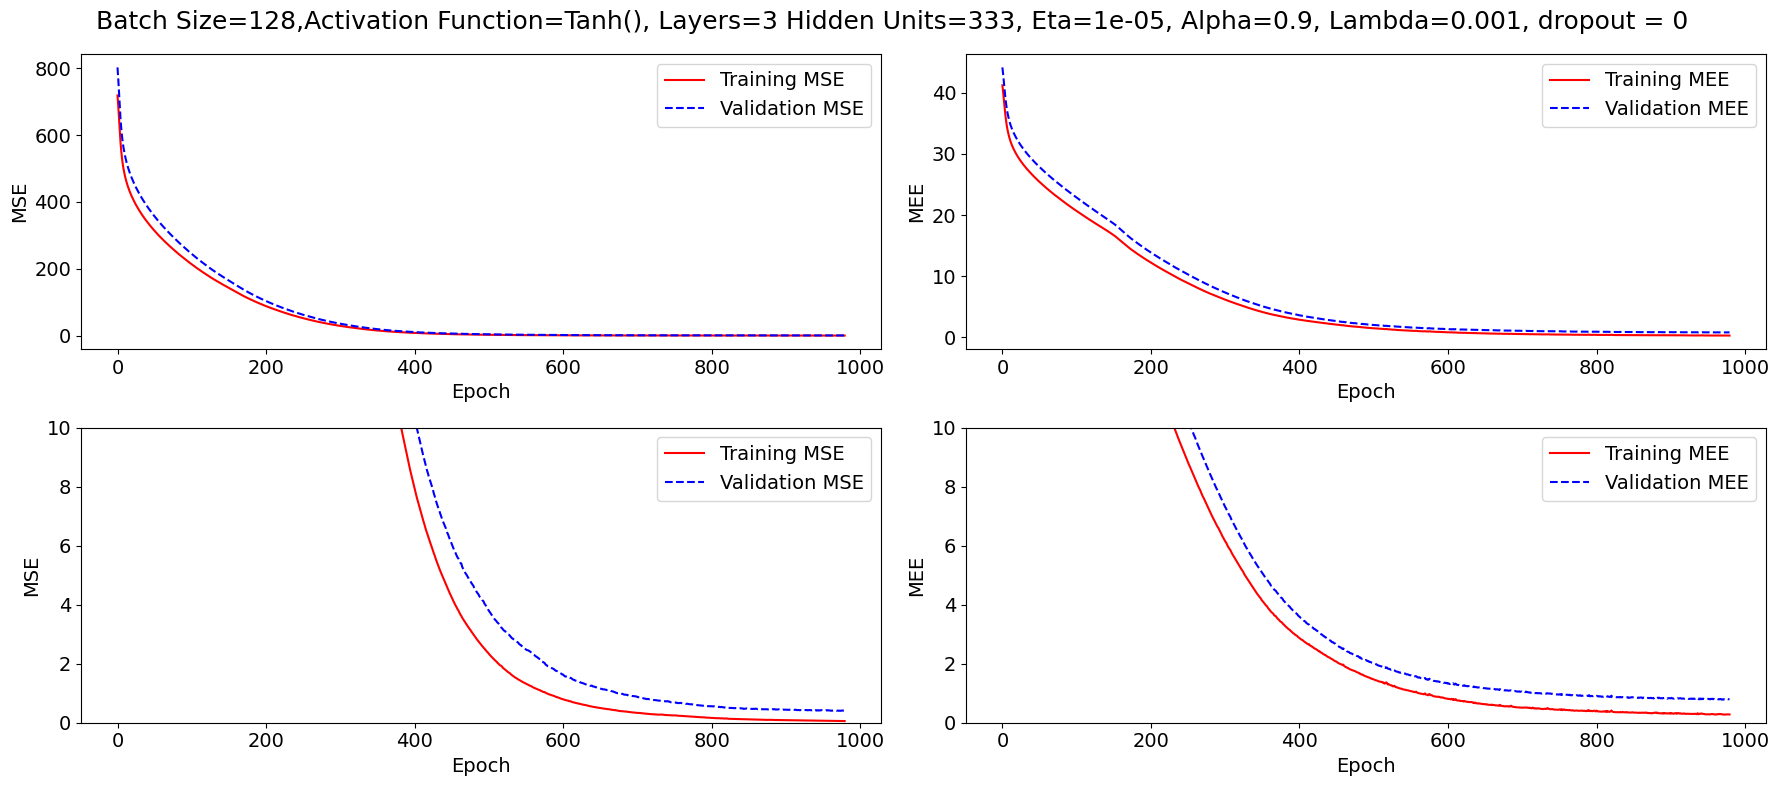

Avg of 3 initializations: Loss (train | test/val )= (0.05443 +- 0.01066 | 0.4113 +- 0.01075)- MEE (train | test/val ) = ( 0.2775 +-  0.006654 | 0.7844 +- 0.01139)
Final Results: activation=Tanh(); layers=3; neuron number=1000; lr=1e-05; alpha = 0.9; batch size = 128; lambda = 0.001 --> train_loss = 0.04177 +- 0.009806 | val_loss = 0.3878 +- 0.1035train_mee = 0.2695 +- 0.01544 | val_mee = 0.7081 +- 0.1061
[1000, 1e-05, 0.9, 128, 0.001, Tanh(), 3, 0, 0.5, 15] n Best val MEE: 0.7080767287148371


In [15]:
#SGD
'''
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4,2e-4,3e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'SGD' #either 'SGD' or 'Adam'or 'RMS'
#hyperparameters for reducelronplateau:
factors=[0.5,0.6,0.7,0.8,0.9]
lr_patiences=[5,10,15]
'''

#Adam
'''
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-4,2e-4,3e-4]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'Adam' #either 'SGD' or 'Adam'or 'RMS'
#hyperparameters for reducelronplateau:
factors=[0.5,0.6,0.7,0.8,0.9]
lr_patiences=[5,10,15]
'''

#RMSProp
'''
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-5,2e-5,3e-5]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam'or 'RMS'
#hyperparameters for reducelronplateau:
factors=[0.5,0.6,0.7,0.8,0.9]
lr_patiences=[5,10,15]
'''

#Best configuration so far:
#RMSProp
hidden_neurons = [1000] #total number of neurons
learning_rates = [1e-5]
momentums = [0.9] #if optimiz = 'Adam' it doesn't matter
batch_sizes = [128]
reg_coeffs = [1e-3]
activations = [nn.Tanh()]
layerss = [3]
dropouts = [0]
optimiz = 'RMS' #either 'SGD' or 'Adam'or 'RMS'
#hyperparameters for reducelronplateau:
factors=[0.5]
lr_patiences=[15]


best_hp = perform_grid_search_kfold(hidden_neurons,
                                    learning_rates,
                                    momentums,
                                    batch_sizes,
                                    reg_coeffs,
                                    activations,
                                    layerss,
                                    dropouts,
                                    factors,
                                    lr_patiences,
                                    optimiz,
                                    k_folds=3,
                                    x=X_train,
                                    y=y_train,
                                    num_epochs=5000,
                                    number_of_init=3,
                                    plot_curves=True)

# TRAIN THE FINAL MODEL ON ALL THE TRAINING SET

In [ ]:
hidden_neurons = 1000 #total number of neurons
learning_rate = 1e-5
momentum = 0.9 #if optimiz = 'Adam' it doesn't matter
batch_size = 128
reg_coeff = 1e-3
activation = nn.Tanh()
layers = 3
dropout = 0
optimiz = 'RMS' #either 'SGD' or 'Adam' or 'RMS
factor = 0.5
lr_patience = 15

models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               neuron_number=hidden_neurons,
               learning_rate=learning_rate,
               momentum=momentum,
               bs = batch_size,
               reg_coeff= reg_coeff,
               activation= activation,
               layers= layers,
               dropout= dropout,
               factor= factor,
               lr_patience=lr_patience,
               optimiz=optimiz,
               max_num_epochs=5000,
               plot_curves=False,
               return_history=True,
               N=1)


Epoch 00686: reducing learning rate of group 0 to 5.0000e-06.013 | Test - Epoch [686/5000], Loss: 0.3550 MEE: 0.6083       
N. Epochs = 768 - Loss (train | test/val )= (0.03566 | 0.3305 ) - MEE (train | test/val ) = (0.2753 | 0.5803 )0.5803 
Avg of 1 initializations: Loss (train | test/val )= (0.03566 +- 0.0 | 0.3305 +- 0.0)- MEE (train | test/val ) = ( 0.2753 +-  0.0 | 0.5803 +- 0.0)


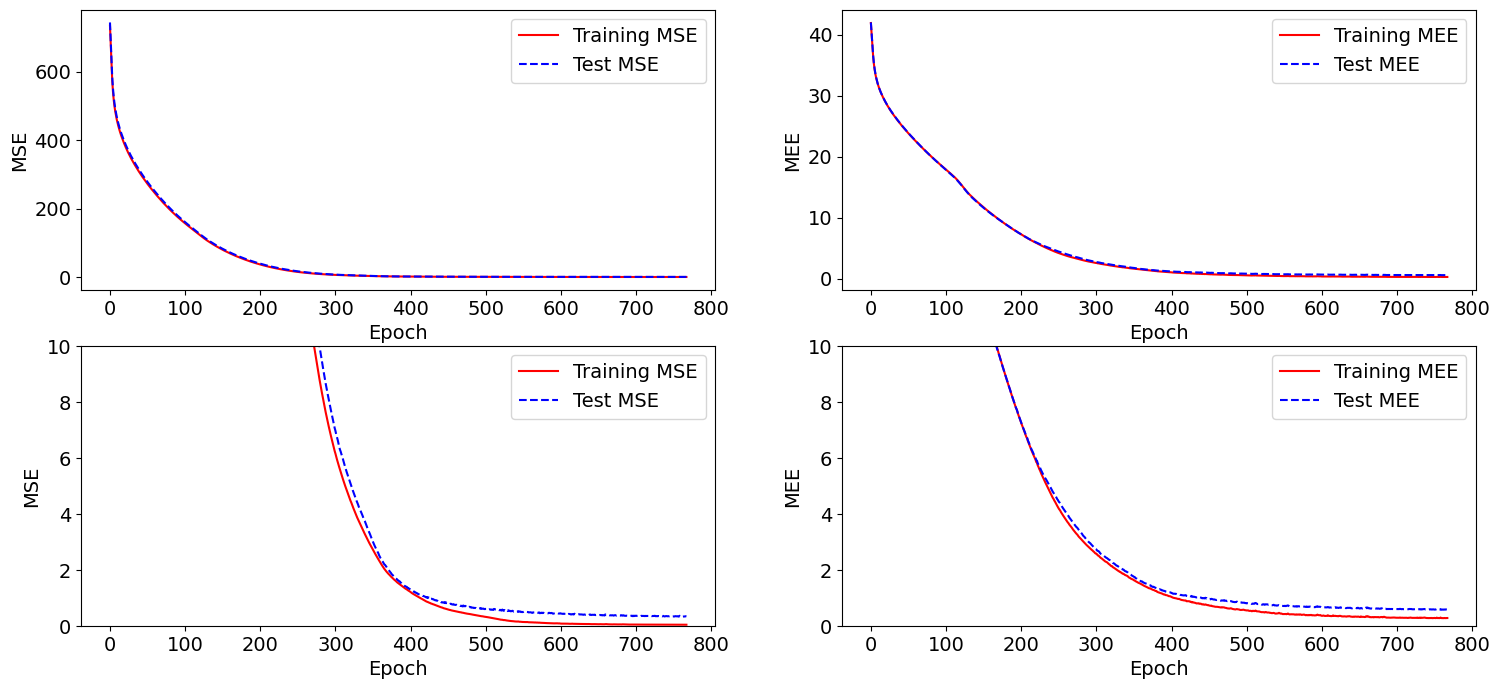

In [ ]:
plt.figure(figsize=(18, 8))
# Loss plots
plt.subplot(2, 2, 1)
plt.plot(train_losses_hist[0], label='Training MSE', color = 'red')
plt.plot(test_losses_hist[0], label='Test MSE', color = 'blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# MEE plots
plt.subplot(2, 2, 2)
plt.plot(train_mees_hist[0], label='Training MEE', color='red')
plt.plot(test_mees_hist[0], label='Test MEE', color = 'blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MEE')
plt.legend()

# Loss plots
plt.subplot(2, 2, 3)
plt.plot(train_losses_hist[0], label='Training MSE', color = 'red')
plt.plot(test_losses_hist[0], label='Test MSE', color = 'blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.ylim(0,10)
plt.legend()

# MEE plots
plt.subplot(2, 2, 4)
plt.plot(train_mees_hist[0], label='Training MEE', color='red')
plt.plot(test_mees_hist[0], label='Test MEE', color = 'blue', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('MEE')
plt.ylim(0,10)
plt.legend()

plt.show()

# Variance from different initializations

In [ ]:
hidden_neurons = 1000 #total number of neurons
learning_rate = 1e-5
momentum = 0.9 #if optimiz = 'Adam' it doesn't matter
batch_size = 128
reg_coeff = 1e-3
activation = nn.Tanh()
layers = 3
dropout = 0
optimiz = 'RMS' #either 'SGD' or 'Adam' or 'RMS
factor = 0.5
lr_patience = 15

models, train_losses_hist, test_losses_hist, train_mees_hist, test_mees_hist = train_with_different_initializations(x_train=X_train,
               y_train=y_train,
               x_test=X_test,
               y_test=y_test,
               neuron_number=hidden_neurons,
               learning_rate=learning_rate,
               momentum=momentum,
               bs = batch_size,
               reg_coeff= reg_coeff,
               activation= activation,
               layers= layers,
               dropout= dropout,
               factor= factor,
               lr_patience=lr_patience,
               optimiz=optimiz,
               max_num_epochs=5000,
               plot_curves=False,
               return_history=True,
               N=5)


Epoch 00799: reducing learning rate of group 0 to 5.0000e-06.726 | Test - Epoch [799/5000], Loss: 0.3017 MEE: 0.5875   9   
N. Epochs = 831 - Loss (train | test/val )= (0.03387 | 0.2897 ) - MEE (train | test/val ) = (0.2561 | 0.5643 )0.5643 
Epoch 00691: reducing learning rate of group 0 to 5.0000e-06.229 | Test - Epoch [691/5000], Loss: 0.3403 MEE: 0.6262   4   
Epoch 00763: reducing learning rate of group 0 to 2.5000e-06.927 | Test - Epoch [763/5000], Loss: 0.3073 MEE: 0.5947 
Epoch 00791: reducing learning rate of group 0 to 1.2500e-06..2809 | Test - Epoch [791/5000], Loss: 0.3040 MEE: 0.5820 
N. Epochs = 814 - Loss (train | test/val )= (0.03893 | 0.302 ) - MEE (train | test/val ) = (0.2758 | 0.5791 )EE: 0.5791 
Epoch 00708: reducing learning rate of group 0 to 5.0000e-06.078 | Test - Epoch [708/5000], Loss: 0.3463 MEE: 0.6453   7   
N. Epochs = 808 - Loss (train | test/val )= (0.03869 | 0.3137 ) - MEE (train | test/val ) = (0.2679 | 0.6034 )0.6034 
Epoch 00696: reducing learning ra

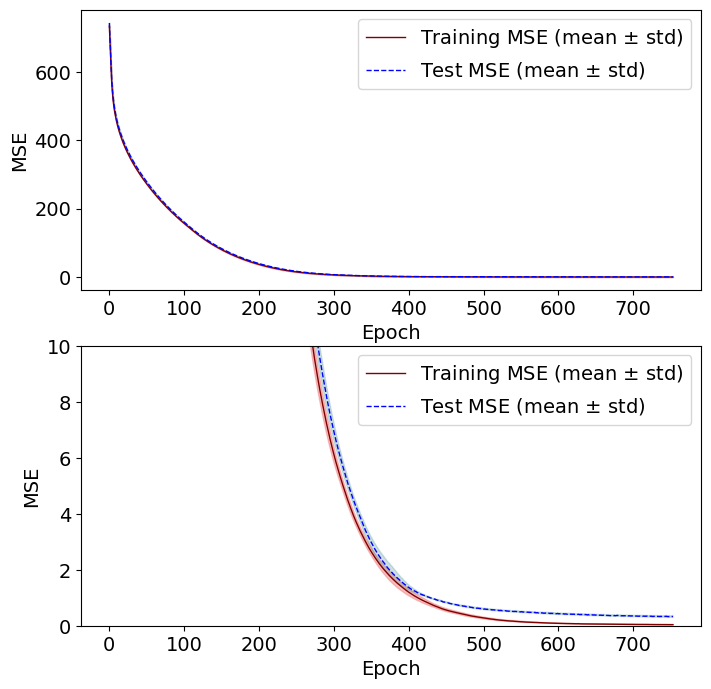

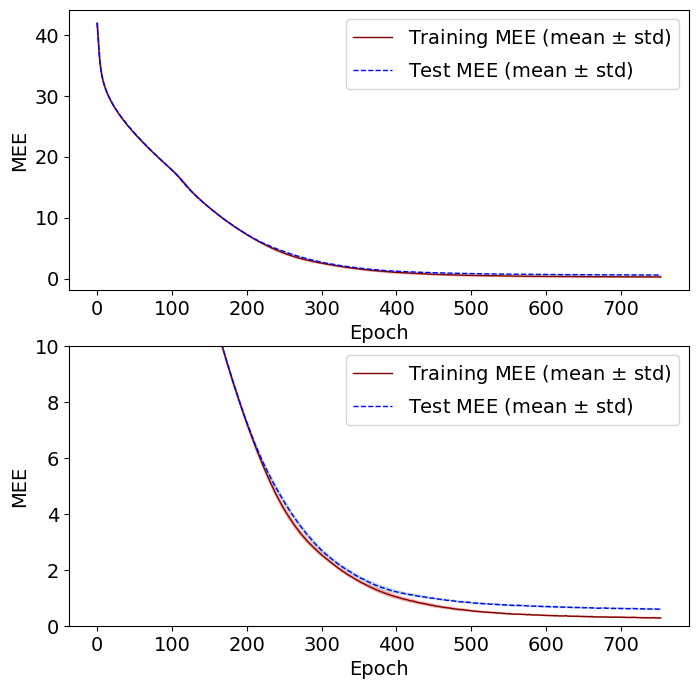

In [ ]:
plot_mean_std(N=5,train_hist=train_losses_hist,test_hist=test_losses_hist,label='MSE')
plot_mean_std(N=5,train_hist=train_mees_hist,test_hist=test_mees_hist,label='MEE')